Сурков Максим

### Реализовано по статье https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

# Обработка сигналов и подсчет Mel-frequency filter banks, MFCCs (Mel frequency cepstral coefficient)

In [305]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import wave
import IPython

In [306]:
MILLISECONDS_IN_SECOND = 1000

In [307]:
def show_signal_graph(signal, rate, mode='frames'):   
    plt.figure(figsize=(15, 2))
    plt.grid(True)
    if mode == 'frames':
        xs = np.arange(len(signal))
    elif mode == 'seconds':  # seconds
        xs = np.linspace(0, len(signal) // rate, num=len(signal))
    elif mode == 'ms':
        xs = np.linspace(0, (len(signal) // rate) * MILLISECONDS_IN_SECOND, num=len(signal))
    else:
        raise Exception(f'unexpected mode = {mode}')
    plt.xlabel(mode)
    plt.plot(xs, signal)

In [308]:
sample_rate, signal = scipy.io.wavfile.read('OSR_us_000_0010_8k.wav')

In [309]:
sample_rate

8000

In [310]:
signal = signal[0:int(3.5 * sample_rate)]

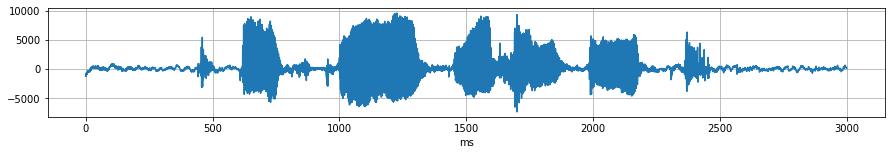

In [311]:
show_signal_graph(signal, sample_rate, mode='ms')

In [312]:
IPython.display.Audio(signal, rate=sample_rate)

## Подготовка сигнала

Применим фильтр

$y(t) = x(t) - \alpha x(t - 1),$

$y(0) = x(0),$

$ \alpha \approx [0.95, 0.97]$

Причины:

* баланс амплитуд и спектра (высокочастотные сигналы часто имеют меньшую амплитуду)

* уменьшает ошибки вычислений при применении преобразований Фурье

* может улучшить SNR (signal-to-noise ratio): чем больше, тем лучше (шум меньше влияет)

In [313]:
PRE_EMPHASIS_ALPHA = 0.96

In [314]:
emphasized_signal = np.append(signal[0], signal[1:] - PRE_EMPHASIS_ALPHA * signal[:-1])

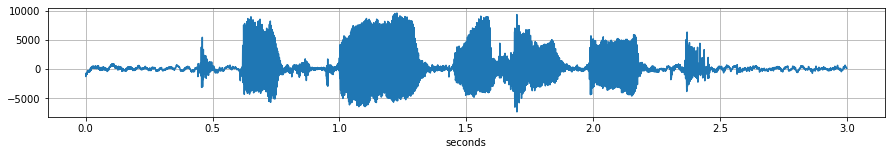

In [315]:
show_signal_graph(signal, sample_rate, mode='seconds')

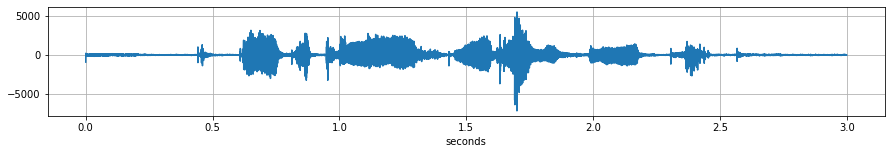

In [316]:
show_signal_graph(emphasized_signal, sample_rate, mode='seconds')

## Разделение на фреймы

Достаточно бессмысленно применять преобразование Фурье ко всему сигналу, т.к. многие сигналы появляются в разные моменты времени. Таким образом можно потерять большое количество информации. Чтобы избежать этого, давайте разобьем сигнал на окна небольшой ширины с перекрытиями и будем применять Фурье к каждому окну.

#### Типичные константы для случая распознования речи.

Размер окна от $20$ мс до $40$ мс с $50\%\pm 10\%$ перекрытием (overlap), т.е. размер шага (stride) $\approx 50\%$

Суффикс `_s` - секунды

Суффикс `_f` - фреймы

In [317]:
WINDOW_SIZE_S = 0.025
STRIDE_S = WINDOW_SIZE_S * 0.5

In [318]:
signal_size_f = len(signal)
window_size_f = int(WINDOW_SIZE_S * sample_rate)
stride_f = int(STRIDE_S * sample_rate)
num_windows = int(np.ceil(max(0, signal_size_f + 1 - window_size_f) / stride_f)) + 1
pad_signal_size_f = (num_windows - 1) * stride_f + window_size_f

In [319]:
print(signal_size_f, window_size_f, stride_f, num_windows, pad_signal_size_f)

28000 200 100 280 28100


In [320]:
pad_signal = np.append(signal, np.zeros((pad_signal_size_f - signal_size_f)))

In [321]:
indices = np.tile(np.arange(window_size_f), (num_windows, 1)) + np.tile(np.arange(0, num_windows * stride_f, stride_f), (window_size_f, 1)).T

In [322]:
windows = pad_signal[indices]

Добавим немного магии, а именно применим `Hamming window`, которая задается следующим образом:

$w_n = 0.54 - 0.46\cdot\cos\left(\frac{2\pi n}{N - 1}\right)$, где $N$ - размер окна, чтобы

уменьшить `spectral leakage`

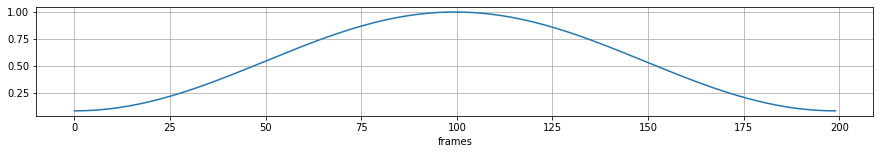

In [323]:
show_signal_graph(np.hamming(window_size_f), sample_rate, 'frames')

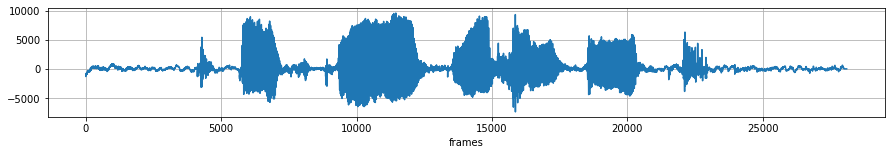

In [324]:
show_signal_graph(pad_signal, sample_rate, mode='frames')

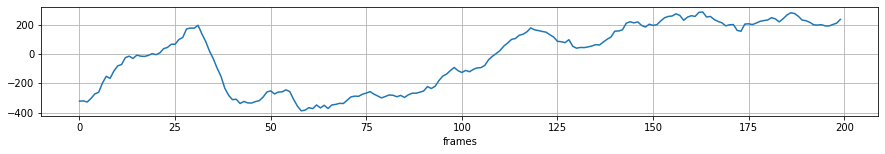

In [325]:
show_signal_graph(windows[50], sample_rate, mode='frames')

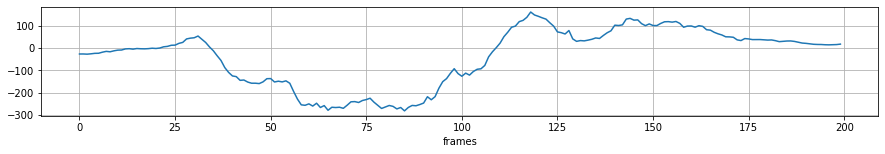

In [326]:
show_signal_graph(windows[50] * np.hamming(window_size_f), sample_rate, mode='frames')

In [327]:
windows *= np.hamming(window_size_f)

Теперь у нас есть несколько окон $w_i$ длины $N = windows\_size\_f$

Давайте для каждого окна посчитаем FFT, найдем магнитуду и `power spectrum (periodogram)`

In [328]:
# finds the minimal power of 2 grater than or equal to n
def find_nfft(n):
    pw = 1
    while pw < n:
        pw *= 2
    return pw

In [329]:
NFFT = find_nfft(window_size_f) * 2

In [330]:
NFFT

512

In [331]:
windows_mag = np.absolute(np.fft.rfft(windows, NFFT))  # magnitudes of FFT
windows_power = (1.0 / NFFT) * ((windows_mag) ** 2)  # power spectrum

In [332]:
print(windows_mag.shape, windows_power.shape)

(280, 257) (280, 257)


Введем понятие Mel-частоты (Mel-frequence)

$m = C_1\log_{10}(1 + \frac f {C_2})$

$f = C_2(10^{m/{C_1}} - 1)$

Возьмем

$C_1 = 2595$

$C_2 = 700$

Mel-scale нужен для того, чтобы имитировать нелинейное восприятие звука человеческим ухом (большее внимание уделется низким частотам).

Для того, чтобы посчитать `filter banks`, осталось применить еще один вид фильтров к
эергитическмоу спектру (`power spectrum`)

Определим семейство фильтров $H_m(k)$, где $1 \le m \le 40$ ($40$ фильтров), фильтр применяется к частоте.

$f(m) = g(m) \cdot \frac{NFFT + 1}{sample\_rate}$

$g(m)$ - преобразование Mel-frequency в обычную частоту в Hz

$
H_m(k) = \begin{cases}
0, & k < f(m - 1) \\
\frac{k - f(m - 1)}{f(m) - f(m - 1)}, & f(m - 1) \le k < f(m) \\
1, & k = f(m) \\
\frac{f(m + 1) - k}{f(m + 1) - f(m)}, & f(m) < k \le f(m + 1) \\
0, & k > f(m + 1) \\
\end{cases}
$

In [333]:
def hz_to_mel(C1, C2, f):
    return C1 * np.log10(1 + f / C2)

def mel_to_hz(C1, C2, m):
    return C2 * (10 ** (m / C1) - 1)

In [334]:
C1 = 2595
C2 = 700
N_FILTERS = 40

In [335]:
low_freq_mel = hz_to_mel(C1, C2, 0)
high_freq_mel = hz_to_mel(C1, C2, sample_rate / 2)

In [336]:
mel_points = np.linspace(low_freq_mel, high_freq_mel, N_FILTERS + 2)
hz_points = mel_to_hz(C1, C2, mel_points)
fs = (NFFT + 1) * hz_points / sample_rate

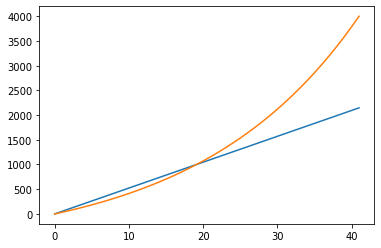

In [337]:
plt.plot(mel_points, label='mel')
plt.plot(hz_points, label='hz')

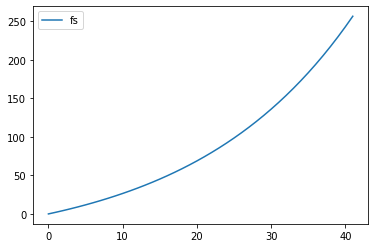

In [338]:
plt.plot(fs, label='fs')
plt.legend()

In [339]:
H = np.zeros((N_FILTERS, int(np.floor(NFFT / 2)) + 1))
for m in range(1, N_FILTERS + 1):
    for k in range(H.shape[1]):
        if fs[m - 1] <= k < fs[m]:
            H[m - 1, k] = (k - fs[m - 1]) / (fs[m] - fs[m - 1])
        elif fs[m] < k <= fs[m + 1]:
            H[m - 1, k] = (fs[m + 1] - k) / (fs[m + 1] - fs[m])

(40, 257)


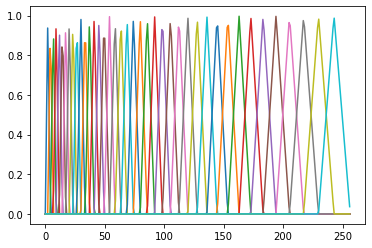

In [340]:
print(H.shape)
for Hm in H:
    plt.plot(Hm)

In [341]:
print(windows_power.shape)

(280, 257)


In [342]:
filter_banks = windows_power @ H.T
filter_banks[filter_banks == 0] = np.finfo(float).eps
filter_banks = 20 * np.log10(filter_banks)

In [343]:
filter_banks.shape

(280, 40)

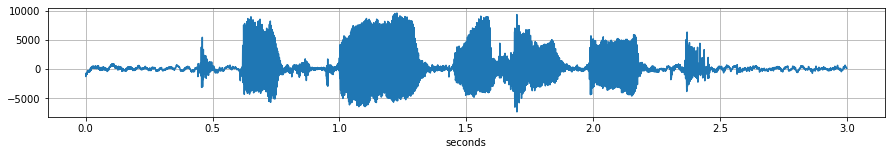

In [344]:
show_signal_graph(signal, rate=sample_rate, mode='seconds')

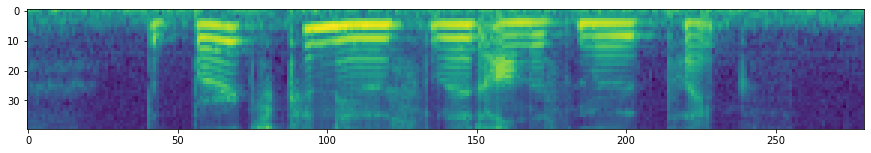

In [345]:
plt.figure(figsize=(15, 20))
plt.imshow(filter_banks.T)

# MFCCs (Mel-frequency cepstral coefficients)

Мы посчитали `filter-banks`, заметим, что коэффициенты сильно коррелируеют между собой, это может стать проблемой для некоторых алгоритмов машинного обучения. Починим (процесс иногда называют decorrelating/whitening). Применим `Discrete Cosine Transform (DCT)`.

Далее применим `sine-liftering`.

Для нейронок не очень полезная штука =(

### Нормализация

Чтобы улучшить SNR также бывает полезно нормализовывать полученные результаты (`filter_banks` / `mfcc`)

In [347]:
filter_banks -= np.mean(filter_banks, axis=0)

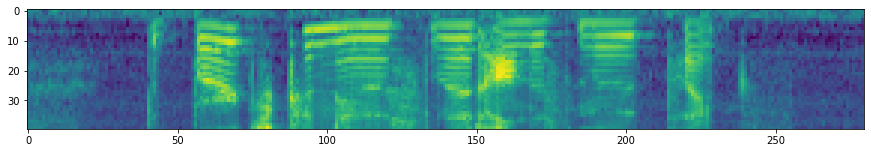

In [348]:
plt.figure(figsize=(15, 20))
plt.imshow(filter_banks.T)

## Filter banks VS MFCCs

MFCCs нужен для того, чтобы уменьшить зависимость между коэффициентами в `filter banks`, это важно для некоторых алгоритмов машинного обучения, однако с появлением DNN нужна ли эта операция сейчас? Её все еще можно использовать, однако, на практике большого прироста качества этот шаг не даст, однако займет процессорное время. А нужно ли тогда DFT? (ведь нейронки умные и могут научиться чему угодно). Ответ: да, лучше использовать, т.к. DFT довольно сложная операция и нейронкам нужно много времени и ресурсов, чтобы этому научиться. Также, стоит заметить, что мы применяем DFT к довольно узким окнам, поэтому эта операция не должна требовать больших ресурсов.